In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

print(pd.__version__)
print(tf.__version__)

0.19.2
1.2.0


In [2]:
batch_size = 128
d_x = 1
d_y = 1

target_stock = 'AAPL'
stock_list = [target_stock]
n_stocks = 1

start_date = '20150101'
end_date = '20151231'

n_ms = 2000
sampling_freq = ('%dms' % n_ms)

# Read data in folder

In [3]:
folder_name = '/scratch/belletti/trade_data/'
colnames = ['date',
            'time',
            'ex',
            'symbol',
            'trade_cond',
            'size',
            'price',
            'stopinf',
            'corr',
            'seqnum',
            'source',
            'rf']

def read_from_csv(stock, date):
    
    local_file_path = folder_name + ('%s_%s.csv.gz' % (date, stock))
    
    try:
        df = pd.read_csv(
            local_file_path,
            names=None,
            parse_dates={'datetime': ['date', 'time']}, 
            compression='gzip',
            engine='c').set_index('datetime')
    except IOError as e:
        return None
    
    return df[['price', 'size']]

In [4]:
dates = pd.date_range(start_date, end_date).map(lambda x: ''.join(str(x).split(' ')[0].split('-')))

data_set = [read_from_csv(stock, date)
            for date in dates
            for stock in stock_list]

In [5]:
valid_dates = [dates[i] for i in xrange(len(dates)) if data_set[i] is not None]
data_set = [x for x in data_set if x is not None]

In [6]:
data_set[0]

,price,size
datetime,,
2015-01-02 04:00:00.019,111.00,100
2015-01-02 04:05:18.110,110.97,300
2015-01-02 04:09:03.440,110.97,40
2015-01-02 04:35:11.488,111.03,200
2015-01-02 04:37:56.331,111.05,106
2015-01-02 04:37:56.331,111.05,53
2015-01-02 04:39:30.647,111.00,800
2015-01-02 04:41:16.702,111.00,1200
2015-01-02 04:44:28.623,110.95,100


In [7]:
def remove_outliers_trades(time_series, window=1000):
    
    time_series['size_upper_bound'] = pd.rolling_quantile(time_series['size'],
                                                     window=window,
                                                     quantile=0.99,
                                                     min_periods=1)
    time_series['size_lower_bound'] = pd.rolling_quantile(time_series['size'],
                                                     window=window,
                                                     quantile=0.01,
                                                     min_periods=1)
    time_series = time_series[time_series['size'] < time_series['size_upper_bound']]
    time_series = time_series[time_series['size'] > time_series['size_lower_bound']]

    time_series.drop(['size_upper_bound', 'size_lower_bound'], axis = 1)

    time_series['price_upper_bound'] = pd.rolling_quantile(time_series['price'],
                                                     window=window,
                                                     quantile=0.99,
                                                     min_periods=1)
    time_series['price_lower_bound'] = pd.rolling_quantile(time_series['price'],
                                                     window=window,
                                                     quantile=0.01,
                                                     min_periods=1)
    time_series = time_series[time_series['price'] < time_series['price_upper_bound']]
    time_series = time_series[time_series['price'] > time_series['price_lower_bound']]

    time_series = time_series.drop(['price_upper_bound', 'price_lower_bound'], axis = 1)

    price_median = time_series['price'].median()

    time_series = time_series[time_series['price'] > price_median * 0.80]
    time_series = time_series[time_series['price'] < price_median * 1.20]

    return time_series

In [8]:
def resample_trades(date, df):
    
    start_timestamp = pd.to_datetime(date + 'T10:00:00')
    end_timestamp = pd.to_datetime(date + 'T14:00:00')
        
    df = df.resample(sampling_freq).median().fillna(method='pad')    
    complete_result = df[start_timestamp:end_timestamp]['price'].diff()[1:]
    
    n_samples = len(complete_result)
    
    return complete_result.values

In [9]:
resampled_clean_data_set = [resample_trades(date, remove_outliers_trades(intraday)) 
                            for (date, intraday) in zip(valid_dates, data_set)]

/scratch/belletti/tensorflow/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_quantile is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=1000,center=False).quantile(quantile=0.99)
  
/scratch/belletti/tensorflow/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.rolling_quantile is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=1000,center=False).quantile(quantile=0.01)
  # Remove the CWD from sys.path while we load stuff.
/scratch/belletti/tensorflow/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:19: FutureWarning: pd.rolling_quantile is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=1000,center=False).quantile(quantile=0.99)
/scratch/belletti/tensorflow/tensorflow/lib/python2.7/site-packages/ipykernel

In [10]:
n_timestamps_expected = 4 * 3600 * 1000 / n_ms
data_set_array = np.asanyarray([x 
                                for x in resampled_clean_data_set
                                if len(x) == n_timestamps_expected])
print(data_set_array.shape)

(252, 7200)


## Let's visualize a couple of examples

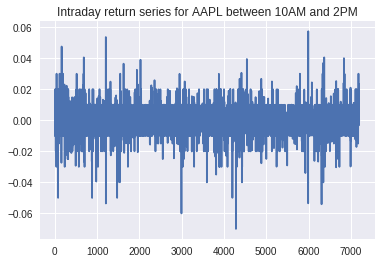

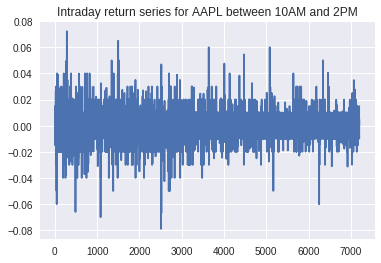

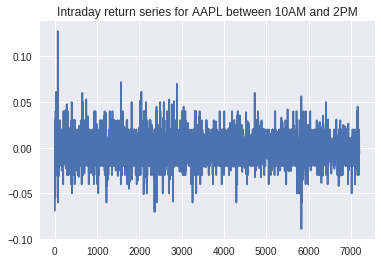

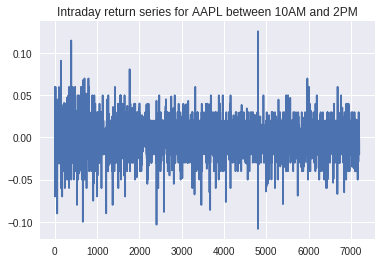

In [11]:
n_days_to_plot = 4

for day in xrange(n_days_to_plot):
    plt.plot(data_set_array[np.random.randint(data_set_array.shape[0])])
    plt.title('Intraday return series for %s between 10AM and 2PM' % target_stock)
    plt.show()    

# Building the network

In [12]:
# We do not assume we know the sequence length yet

x_seq_ph = tf.placeholder(shape=(batch_size, None), dtype=tf.float32)
x_seq = tf.expand_dims(x_seq_ph, axis=-1)

In [13]:
def convolution_layer(input_seq, n_dims_in, n_dims_out, width, 
                      dilation=1, causal=True):
    conv_kernel = tf.get_variable(
        name='kernel',
        shape=[width, n_dims_in, n_dims_out], 
        dtype=tf.float32,
        initializer=tf.truncated_normal_initializer())
    
    # Similar to approach in Francois Chollet's Keras library
    if causal:
        offset = dilation * (width - 1)
        input_seq = tf.pad(input_seq, [[0, 0], [offset, 0], [0, 0]])
    
    conv_output = tf.nn.convolution(
        input=input_seq,
        filter=conv_kernel,
        padding='VALID' if causal else 'SAME',
        strides=None,
        dilation_rate=[dilation]
    )
    
    bias = tf.get_variable(
        name='bias',
        shape=[n_dims_out],
        dtype=tf.float32,
        initializer=tf.zeros_initializer()
    )
    
    return tf.nn.bias_add(conv_output, bias)

In [14]:
def leaky_relu(x, leakiness=0.1):
    """Relu, with optional leaky support."""
    return tf.where(tf.less(x, 0.0), leakiness * x, x, name='leaky_relu')

In [15]:
def build_conv_net(input_seq, kernel_specs, dilations=None, causal=True):

    if dilations is None:
        dilations = [1] * len(kernel_specs)
    
    output_seq = input_seq
    for i, ((n_dims_in, n_dims_out, width), dilation) in enumerate(zip(kernel_specs, dilations)):
        
        with tf.variable_scope('conv_layer_%d' % i):
            output_seq = convolution_layer(output_seq, n_dims_in, n_dims_out, 
                                           dilation, causal)        
            output_seq = leaky_relu(output_seq)
        
    return output_seq

In [16]:
kernel_specs = [
    [1, 2, 4],
    [2, 2, 4],
    [2, 2, 4],
    [2, 1, 4]  
]

predicted = build_conv_net(x_seq[:,:-1,:], kernel_specs, dilations=[1,2,4,8])

to_predict =  x_seq[:,1:,:]

#loss = tf.reduce_sum(tf.nn.l2_loss(predicted - to_predict))
loss = tf.reduce_mean(tf.abs(predicted - to_predict))

In [17]:
learning_rate = 1e-3

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(loss)

In [18]:
n_days = data_set_array.shape[0]
sequence_length = 4096
train_test_split = 0.9
n_days_train = int(n_days * train_test_split)

def generate_train_samples(batch_size):
    selected_days = np.random.choice(range(n_days_train), batch_size)    
    offset = np.random.randint(0, n_timestamps_expected - sequence_length)
    return data_set_array[selected_days, offset:]

def generate_test_samples(batch_size):
    selected_days = np.random.choice(range(n_days_train, n_days), batch_size)    
    offset = np.random.randint(0, n_timestamps_expected - sequence_length)
    return data_set_array[selected_days, offset:]

In [19]:
n_steps = int(2*1e3)

session = tf.Session()

session.run(tf.global_variables_initializer())

train_loss_evals = []
test_loss_evals = []

for step in xrange(n_steps):
    
    x_seq_train_samples = generate_train_samples(batch_size)
    train_loss_eval, _ = session.run((loss, optimizer), 
                                     feed_dict={x_seq_ph: x_seq_train_samples})
    train_loss_evals.append(train_loss_eval)
    
    x_seq_test_samples = generate_test_samples(batch_size)
    test_loss_eval, _ = session.run((loss, optimizer), 
                                    feed_dict={x_seq_ph: x_seq_test_samples})
    test_loss_evals.append(test_loss_eval)

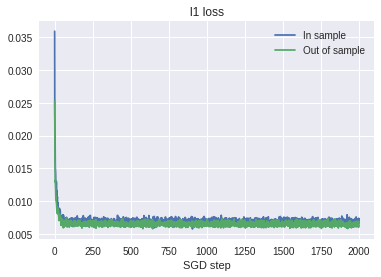

In [20]:
plt.plot(train_loss_evals)
plt.plot(test_loss_evals)
plt.legend(('In sample', 'Out of sample', ))
plt.title('l1 loss')
plt.xlabel('SGD step')
plt.show()

In [21]:
print(np.mean(test_loss_evals[-200:]))

0.00642921
